Impulse Noise Restoration via CSC
=================================

This example demonstrates the removal of salt & pepper noise from a hyperspectral image using convolutional sparse coding, with a product dictionary [[24]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2018-convolutional2) and with an :math:`\ell_1` data fidelity term, an :math:`\ell_1` regularisation term, and an additional gradient regularization term [[49]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional2)

  $$\mathrm{argmin}_X \; \left\| D X B^T - S \right\|_1 + \lambda \| X \|_1 + (\mu / 2) \sum_i \| G_i X \|_2^2$$

where $D$ is a convolutional dictionary, $B$ is a standard dictionary, $G_i$ is an operator that computes the gradient along array axis $i$, and $S$ is a multi-channel input image.

This example uses the GPU accelerated version of [admm.pdcsc](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#module-sporco.admm.pdcsc) within the [sporco.cupy](http://sporco.rtfd.org/en/latest/modules/sporco.cupy.html#module-sporco.cupy) subpackage.

In [1]:
from __future__ import print_function
from builtins import input

import os.path
import tempfile
import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np
import scipy.io as sio

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
from sporco.linalg import pca
from sporco.metric import psnr
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import pdcsc

Boundary artifacts are handled by performing a symmetric extension on the image to be denoised and then cropping the result to the original image support. This approach is simpler than the boundary handling strategies that involve the insertion of a spatial mask into the data fidelity term, and for many problems gives results of comparable quality. The functions defined here implement symmetric extension and cropping of images.

In [2]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

Load a reference hyperspectral image and corrupt it with 33% salt and pepper noise. (The call to ``np.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
pth = os.path.join(tempfile.gettempdir(), 'Indian_pines.mat')
if not os.path.isfile(pth):
    url = 'http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat'
    vid = util.netgetdata(url)
    f = open(pth, 'wb')
    f.write(vid.read())
    f.close()

img = sio.loadmat(pth)['indian_pines'].astype(np.float32)
img = img[16:-17, 16:-17, 0:200:2]
img /= img.max()

np.random.seed(12345)
imgn = signal.spnoise(img, 0.33)

We use a product dictionary [[24]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2018-convolutional2) constructed from a single-channel convolutional dictionary for the spatial axes of the image, and a truncated PCA basis for the spectral axis of the image. The impulse denoising problem is solved by appending an additional filter to the learned dictionary ``D0``, which is one of those distributed with SPORCO. This additional component consist of an impulse filters that will represent the low frequency image components when used together with a gradient penalty on the coefficient maps, as discussed below. The PCA basis is computed from the noise-free ground-truth image since the primary purpose of this script is as a code usage example: in a real application, the PCA basis would be estimated from a relevant noise-free image, or could be estimated from the noisy image via Robust PCA.

In [4]:
D0 = util.convdicts()['G:8x8x32']
Di = np.zeros(D0.shape[0:2] + (1,), dtype=np.float32)
Di[0, 0] = 1.0
D = np.concatenate((Di, D0), axis=2)

S = img.reshape((-1, img.shape[-1])).T
pcaB, pcaS, pcaC = pca(S, centre=False)
B = pcaB[:, 0:20]

The problem is solved using class [admm.pdcsc.ConvProdDictL1L1GrdJoint](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#sporco.admm.pdcsc.ConvProdDictL1L1GrdJoint), which implements a convolutional sparse coding problem with a product dictionary [[24]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2018-convolutional2), an :math:`\ell_1` data fidelity term, an :math:`\ell_1` regularisation term, and an additional gradient regularization term [[49]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional2), as defined above. The regularization parameters for the $\ell_1$ and gradient terms are ``lmbda`` and ``mu`` respectively. Setting correct weighting arrays for these regularization terms is critical to obtaining good performance. For the $\ell_1$ norm, the weights on the filters that are intended to represent low frequency components are set to zero (we only want them penalised by the gradient term), and the weights of the remaining filters are set to zero. For the gradient penalty, all weights are set to zero except for those corresponding to the filters intended to represent low frequency components, which are set to unity.

In [5]:
lmbda = 4.2e0
mu = 9.5e0

Set up weights for the $\ell_1$ norm to disable regularization of the coefficient map corresponding to the impulse filter.

In [6]:
wl1 = np.ones((1,)*4 + (D.shape[2],), dtype=np.float32)
wl1[..., 0] = 0.0

Set of weights for the $\ell_2$ norm of the gradient to disable regularization of all coefficient maps except for the one corresponding to the impulse filter.

In [7]:
wgr = np.zeros((D.shape[2]), dtype=np.float32)
wgr[0] = 1.0

Set [admm.pdcsc.ConvProdDictL1L1GrdJoint](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#sporco.admm.pdcsc.ConvProdDictL1L1GrdJoint) solver options.

In [8]:
opt = pdcsc.ConvProdDictL1L1GrdJoint.Options(
    {'Verbose': True, 'MaxMainIter': 100, 'RelStopTol': 5e-3,
     'AuxVarObj': False, 'rho': 1e1, 'RelaxParam': 1.8,
     'L21Weight': np2cp(wl1), 'GradWeight': np2cp(wgr)})

Initialise the [admm.pdcsc.ConvProdDictL1L1GrdJoint](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#sporco.admm.pdcsc.ConvProdDictL1L1GrdJoint) object and call the ``solve`` method.

In [9]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = pdcsc.ConvProdDictL1L1GrdJoint(np2cp(D), np2cp(B), np2cp(pad(imgn)),
                              lmbda, mu, opt=opt, dimK=0)
X = cp2np(b.solve())

Running on GPU 1 (GeForce RTX 2080 Ti)



Itn   Fnc       DFid      Regℓ21    Regℓ2∇    r         s       
----------------------------------------------------------------
   0  4.92e+05  3.71e+05  2.87e+04  4.35e+01  4.10e-01  1.72e+00


   1  4.16e+05  3.25e+05  2.16e+04  1.27e+02  4.17e-01  1.25e+00
   2  3.81e+05  3.07e+05  1.73e+04  1.92e+02  2.86e-01  1.16e+00


   3  3.71e+05  3.03e+05  1.57e+04  2.34e+02  2.55e-01  1.16e+00
   4  3.44e+05  2.92e+05  1.19e+04  2.41e+02  1.90e-01  9.29e-01


   5  3.40e+05  2.90e+05  1.12e+04  2.44e+02  1.59e-01  8.97e-01
   6  3.29e+05  2.86e+05  9.62e+03  2.41e+02  1.24e-01  8.41e-01


   7  3.24e+05  2.85e+05  8.74e+03  2.35e+02  1.03e-01  7.24e-01
   8  3.19e+05  2.83e+05  7.95e+03  2.32e+02  8.33e-02  6.43e-01


   9  3.15e+05  2.82e+05  7.24e+03  2.30e+02  6.82e-02  5.70e-01
  10  3.10e+05  2.80e+05  6.72e+03  2.29e+02  5.59e-02  5.11e-01


  11  3.08e+05  2.80e+05  6.25e+03  2.29e+02  4.65e-02  4.59e-01
  12  3.05e+05  2.78e+05  5.83e+03  2.29e+02  3.88e-02  4.19e-01


  13  3.02e+05  2.77e+05  5.46e+03  2.28e+02  3.27e-02  3.87e-01
  14  3.00e+05  2.76e+05  5.16e+03  2.26e+02  2.81e-02  3.62e-01


  15  2.98e+05  2.75e+05  4.82e+03  2.24e+02  2.43e-02  3.44e-01
  16  2.95e+05  2.74e+05  4.47e+03  2.22e+02  2.12e-02  3.27e-01


  17  2.94e+05  2.74e+05  4.28e+03  2.20e+02  1.91e-02  3.12e-01
  18  2.93e+05  2.73e+05  4.16e+03  2.18e+02  1.72e-02  2.98e-01


  19  2.92e+05  2.73e+05  3.98e+03  2.17e+02  1.57e-02  2.86e-01
  20  2.91e+05  2.73e+05  3.80e+03  2.16e+02  1.46e-02  2.75e-01


  21  2.90e+05  2.72e+05  3.70e+03  2.16e+02  1.35e-02  2.66e-01
  22  2.89e+05  2.72e+05  3.60e+03  2.17e+02  1.27e-02  2.59e-01


  23  2.89e+05  2.72e+05  3.44e+03  2.18e+02  1.20e-02  2.52e-01
  24  2.88e+05  2.72e+05  3.30e+03  2.19e+02  1.13e-02  2.46e-01


  25  2.87e+05  2.72e+05  3.22e+03  2.21e+02  1.07e-02  2.41e-01
  26  2.87e+05  2.72e+05  3.12e+03  2.22e+02  1.02e-02  2.35e-01


  27  2.86e+05  2.72e+05  2.99e+03  2.22e+02  9.71e-03  2.30e-01
  28  2.86e+05  2.72e+05  2.90e+03  2.23e+02  9.27e-03  2.26e-01


  29  2.86e+05  2.72e+05  2.84e+03  2.23e+02  8.92e-03  2.23e-01
  30  2.86e+05  2.72e+05  2.76e+03  2.23e+02  8.52e-03  2.20e-01


  31  2.85e+05  2.72e+05  2.64e+03  2.24e+02  8.15e-03  2.17e-01
  32  2.85e+05  2.72e+05  2.55e+03  2.24e+02  7.82e-03  2.14e-01


  33  2.84e+05  2.72e+05  2.47e+03  2.24e+02  7.51e-03  2.12e-01
  34  2.84e+05  2.72e+05  2.39e+03  2.24e+02  7.20e-03  2.10e-01


  35  2.83e+05  2.72e+05  2.31e+03  2.25e+02  6.93e-03  2.08e-01
  36  2.83e+05  2.71e+05  2.24e+03  2.25e+02  6.66e-03  2.06e-01


  37  2.83e+05  2.71e+05  2.18e+03  2.26e+02  6.41e-03  2.04e-01
  38  2.82e+05  2.71e+05  2.11e+03  2.27e+02  6.17e-03  2.02e-01


  39  2.82e+05  2.71e+05  2.06e+03  2.27e+02  5.95e-03  2.00e-01
  40  2.82e+05  2.71e+05  2.02e+03  2.28e+02  5.74e-03  1.98e-01


  41  2.82e+05  2.71e+05  1.97e+03  2.29e+02  5.54e-03  1.96e-01
  42  2.81e+05  2.71e+05  1.92e+03  2.29e+02  5.35e-03  1.95e-01


  43  2.81e+05  2.71e+05  1.87e+03  2.30e+02  5.15e-03  1.94e-01
  44  2.81e+05  2.71e+05  1.81e+03  2.30e+02  4.97e-03  1.93e-01


  45  2.81e+05  2.71e+05  1.76e+03  2.30e+02  4.80e-03  1.92e-01
  46  2.80e+05  2.71e+05  1.70e+03  2.31e+02  4.63e-03  1.91e-01


  47  2.80e+05  2.71e+05  1.66e+03  2.31e+02  4.47e-03  1.90e-01
  48  2.80e+05  2.71e+05  1.63e+03  2.32e+02  4.33e-03  1.89e-01


  49  2.80e+05  2.71e+05  1.60e+03  2.32e+02  4.20e-03  1.88e-01
  50  2.80e+05  2.71e+05  1.56e+03  2.32e+02  4.06e-03  1.87e-01


  51  2.80e+05  2.71e+05  1.52e+03  2.33e+02  3.93e-03  1.86e-01
  52  2.80e+05  2.71e+05  1.49e+03  2.33e+02  3.81e-03  1.85e-01


  53  2.79e+05  2.71e+05  1.46e+03  2.33e+02  3.69e-03  1.85e-01
  54  2.79e+05  2.71e+05  1.42e+03  2.34e+02  3.57e-03  1.84e-01


  55  2.79e+05  2.71e+05  1.39e+03  2.34e+02  3.46e-03  1.83e-01
  56  2.79e+05  2.71e+05  1.35e+03  2.35e+02  3.35e-03  1.83e-01


  57  2.79e+05  2.71e+05  1.32e+03  2.35e+02  3.25e-03  1.82e-01
  58  2.79e+05  2.71e+05  1.29e+03  2.36e+02  3.15e-03  1.82e-01


  59  2.79e+05  2.71e+05  1.27e+03  2.36e+02  3.06e-03  1.81e-01
  60  2.78e+05  2.71e+05  1.24e+03  2.36e+02  2.97e-03  1.81e-01


  61  2.78e+05  2.71e+05  1.22e+03  2.37e+02  2.88e-03  1.81e-01
  62  2.78e+05  2.71e+05  1.20e+03  2.37e+02  2.80e-03  1.80e-01


  63  2.78e+05  2.71e+05  1.17e+03  2.37e+02  2.72e-03  1.80e-01
  64  2.78e+05  2.71e+05  1.15e+03  2.38e+02  2.64e-03  1.79e-01


  65  2.78e+05  2.71e+05  1.13e+03  2.38e+02  2.56e-03  1.79e-01
  66  2.78e+05  2.71e+05  1.11e+03  2.38e+02  2.49e-03  1.79e-01


  67  2.78e+05  2.71e+05  1.09e+03  2.39e+02  2.42e-03  1.78e-01
  68  2.78e+05  2.71e+05  1.07e+03  2.39e+02  2.35e-03  1.78e-01


  69  2.78e+05  2.71e+05  1.04e+03  2.39e+02  2.28e-03  1.78e-01
  70  2.77e+05  2.71e+05  1.02e+03  2.40e+02  2.22e-03  1.78e-01


  71  2.77e+05  2.71e+05  1.01e+03  2.40e+02  2.16e-03  1.77e-01
  72  2.77e+05  2.71e+05  9.91e+02  2.40e+02  2.10e-03  1.77e-01


  73  2.77e+05  2.71e+05  9.77e+02  2.40e+02  2.05e-03  1.77e-01
  74  2.77e+05  2.71e+05  9.62e+02  2.41e+02  1.99e-03  1.77e-01


  75  2.77e+05  2.71e+05  9.46e+02  2.41e+02  1.94e-03  1.76e-01
  76  2.77e+05  2.71e+05  9.30e+02  2.41e+02  1.89e-03  1.76e-01


  77  2.77e+05  2.71e+05  9.16e+02  2.41e+02  1.84e-03  1.76e-01
  78  2.77e+05  2.71e+05  9.03e+02  2.42e+02  1.79e-03  1.76e-01


  79  2.77e+05  2.71e+05  8.90e+02  2.42e+02  1.74e-03  1.76e-01
  80  2.77e+05  2.71e+05  8.77e+02  2.42e+02  1.70e-03  1.75e-01


  81  2.77e+05  2.71e+05  8.62e+02  2.42e+02  1.65e-03  1.75e-01
  82  2.77e+05  2.71e+05  8.47e+02  2.43e+02  1.61e-03  1.75e-01


  83  2.77e+05  2.71e+05  8.33e+02  2.43e+02  1.57e-03  1.75e-01
  84  2.77e+05  2.71e+05  8.21e+02  2.43e+02  1.53e-03  1.75e-01


  85  2.77e+05  2.71e+05  8.11e+02  2.43e+02  1.49e-03  1.75e-01
  86  2.77e+05  2.71e+05  8.02e+02  2.43e+02  1.46e-03  1.75e-01


  87  2.76e+05  2.71e+05  7.93e+02  2.44e+02  1.42e-03  1.74e-01
  88  2.76e+05  2.71e+05  7.83e+02  2.44e+02  1.39e-03  1.74e-01


  89  2.76e+05  2.71e+05  7.73e+02  2.44e+02  1.35e-03  1.74e-01
  90  2.76e+05  2.71e+05  7.62e+02  2.44e+02  1.32e-03  1.74e-01


  91  2.76e+05  2.71e+05  7.51e+02  2.44e+02  1.29e-03  1.74e-01
  92  2.76e+05  2.71e+05  7.41e+02  2.44e+02  1.25e-03  1.74e-01


  93  2.76e+05  2.71e+05  7.31e+02  2.45e+02  1.22e-03  1.74e-01
  94  2.76e+05  2.71e+05  7.22e+02  2.45e+02  1.19e-03  1.74e-01


  95  2.76e+05  2.71e+05  7.14e+02  2.45e+02  1.17e-03  1.74e-01
  96  2.76e+05  2.71e+05  7.07e+02  2.45e+02  1.14e-03  1.73e-01


  97  2.76e+05  2.71e+05  6.99e+02  2.45e+02  1.11e-03  1.73e-01
  98  2.76e+05  2.71e+05  6.91e+02  2.45e+02  1.09e-03  1.73e-01


  99  2.76e+05  2.71e+05  6.83e+02  2.46e+02  1.06e-03  1.73e-01
----------------------------------------------------------------


The denoised estimate of the image is just the reconstruction from all coefficient maps.

In [10]:
imgdp = cp2np(b.reconstruct().squeeze())
imgd = crop(imgdp)

Display solve time and denoising performance.

In [11]:
print("ConvProdDictL1L1GrdJoint solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % psnr(img, imgd))

ConvProdDictL1L1GrdJoint solve time: 11.35 s
Noisy image PSNR:     8.75 dB
Denoised image PSNR: 38.60 dB


Display the reference, noisy, and denoised images.

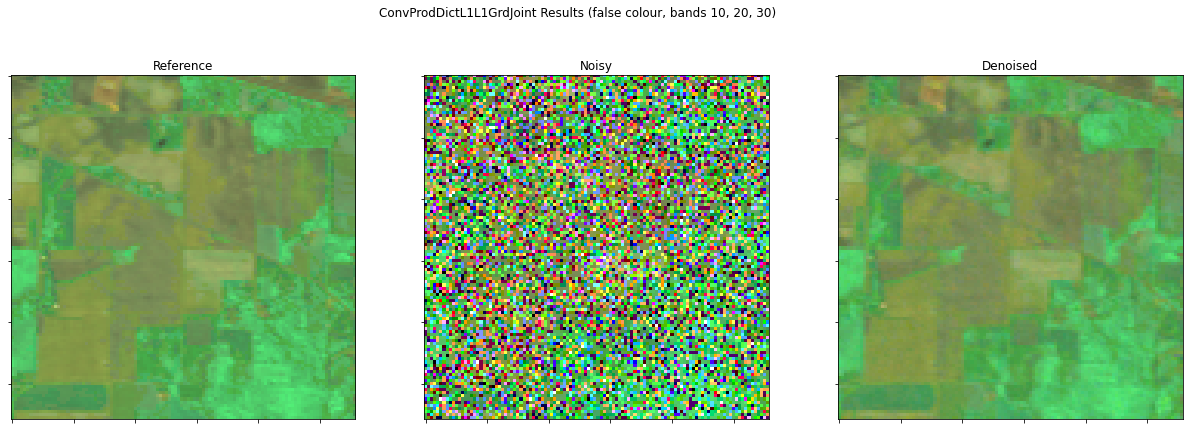

In [12]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('ConvProdDictL1L1GrdJoint Results (false colour, '
             'bands 10, 20, 30)')
plot.imview(img[..., 10:40:10], title='Reference', ax=ax[0], fig=fig)
plot.imview(imgn[..., 10:40:10], title='Noisy', ax=ax[1], fig=fig)
plot.imview(imgd[..., 10:40:10], title='Denoised', ax=ax[2], fig=fig)
fig.show()

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

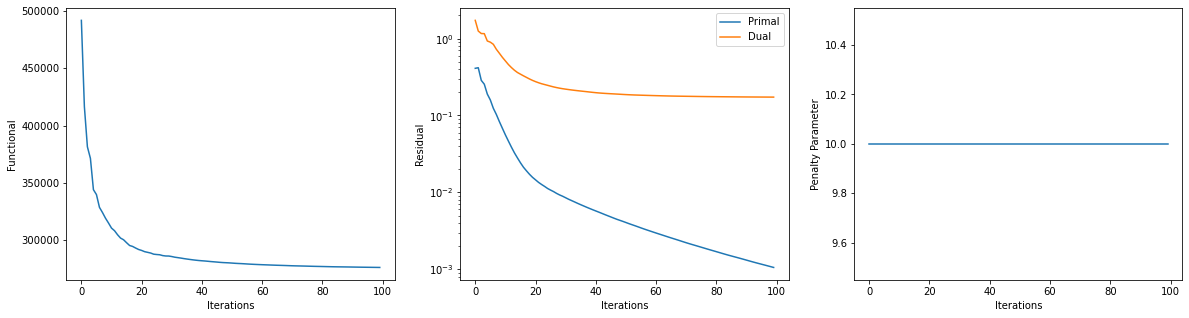

In [13]:
its = b.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()